<a href="https://colab.research.google.com/github/KartikayMann/SkimLit/blob/main/SkimLit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project: SkimLit

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

## Confirm access to a GPU

In [ ]:
!nvidia-smi

Wed Jun 22 12:06:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    33W /  70W |   5248MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Get data


In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
# check what files are in the Pubmed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/


dev.txt  test.txt  train.txt


In [ ]:
# start our experiments using the 20K dataset with numbers replaced by "@" sign

data_dir="/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"


In [ ]:
# check all of the filenames in the target directory

import os
filenames=[data_dir+filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Preprocess data

In [ ]:
# Create function to read the lines of a document

def get_lines(filename):
  """
  Reads text filename and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """

  with open(filename,"r") as f:
    return f.readlines()
    


In [ ]:
#  Let's read in the training line
train_lines=get_lines(data_dir+"train.txt") # read the lines within training files
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
len(train_lines)

210040

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename,reads its contents and sorts through each line, extracting
  things like the target label, the text of the sentence, how many sentences are
  in the current abstract and what sentence number the target line is.
  """

  input_lines=get_lines(filename) # get all lines from filename
  abstract_lines="" # create an empty abstract
  abstract_samples=[] # create a empty list of abstracts

  # loop through each line in the target file
  for line in input_lines:
    if line.startswith('###'): # check to see if this is an ID line
      abstract_id=line
      abstract_lines="" # reset the abstract string if the line is an ID line

    elif line.isspace(): # check to see if line is a new line
      abstract_line_split=abstract_lines.splitlines() # split abstract into seperate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number,abstract_line in enumerate(abstract_line_split):
        line_data={} # create an empty dictionary for each line
        target_text_split=abstract_line.split("\t") # split target label from text
        line_data["target"]=target_text_split[0] # get target label
        line_data["text"]=target_text_split[1].lower() # get target text and lower it
        line_data["line_number"]=abstract_line_number # what number the line appear in the abstract
        line_data["total_lines"]=len(abstract_line_split)-1 # total lines in the target abstract
        abstract_samples.append(line_data) # add line data to abstract samples list
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines+=line

  return abstract_samples





In [ ]:
# Get data from file and preprocess it

%%time
train_samples=preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples=preprocess_text_with_line_numbers(data_dir+"dev.txt")
test_samples=preprocess_text_with_line_numbers(data_dir+"test.txt")

print(len(train_samples),len(val_samples),len(test_samples))

180040 30212 30135
CPU times: user 448 ms, sys: 108 ms, total: 556 ms
Wall time: 592 ms


In [ ]:
# check the first abstract of our training data
train_samples[:10]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [ ]:
import pandas as pd
train_df=pd.DataFrame(train_samples)
test_df=pd.DataFrame(test_samples)
val_df=pd.DataFrame(val_samples)

train_df.head(15)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
# Distribution of labels in training data

train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

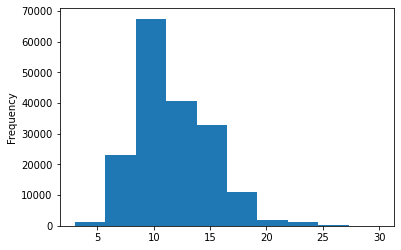

In [ ]:
# check length of different lines
train_df.total_lines.plot.hist();

### Get lists of sentences

In [ ]:
# Convert abstract text lines into lists

train_sentences=train_df["text"].to_list()
test_sentences=test_df["text"].to_list()
val_sentences=val_df["text"].to_list()

len(train_sentences),len(val_sentences),len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# view the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models require numeric labels)

In [ ]:
# one hot encode labels
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder=OneHotEncoder(sparse=False) # we want non-sparse matrix
train_labels_one_hot=one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot=one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot=one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1,1))
# check one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [ ]:
# Extract labels ("target" columns) and encode them into integers

from sklearn.preprocessing import LabelEncoder

label_encoder=LabelEncoder()
train_labels_encoded=label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded=label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded=label_encoder.transform(test_df["target"].to_numpy())

# check what training labels look like

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from LabelEncoder instance

num_classes =len(label_encoder.classes_)
class_names=label_encoder.classes_
num_classes,class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Model 0: Getting a baseline


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# create a pipeline
model_0=Pipeline([
      ("tf-idf",TfidfVectorizer()),
      ("clf",MultinomialNB())
])

# fit the pipeline to the training data

model_0.fit(X=train_sentences,
            y=train_labels_encoded)


Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [ ]:
# make predictions using our baseline model

baseline_preds=model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

### Download helper function script

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-06-22 12:07:08--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-22 12:07:09 (83.2 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results


In [ ]:
baseline_results=calculate_results(y_true=val_labels_encoded,
                                   y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Preparing our data (the text) for deep sequence models


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# how long is each sentence on average

sent_len=[len(sentence.split()) for sentence in train_sentences]
avg_sent_len=np.mean(sent_len)
avg_sent_len 

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <a list of 20 Patch objects>)

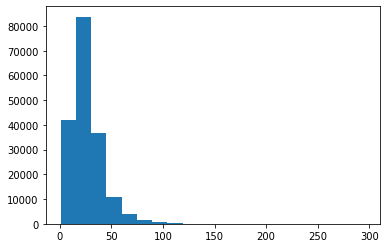

In [ ]:
# the distribution

import matplotlib.pyplot as plt

plt.hist(sent_len,bins=20)

In [ ]:
# which sentence length convers 95% of examples

output_seq_len=int(np.percentile(sent_len,95))
output_seq_len

55

In [ ]:
# max sequence len in training set

max(sent_len)

296

### Create text vectorizer layer

we want a layer which maps our texts from words to numbers

In [ ]:
# number of words in our vocabulary

max_tokens=68000


In [ ]:
from typing import Sequence
# create text vectorizer

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer=TextVectorization(max_tokens=max_tokens, # number of words in vocabulary  
                                  output_sequence_length=output_seq_len, # desired output length of vectorized sequences
                                  pad_to_max_tokens=True)

In [ ]:
# adapt text vectorizer to training sentences

text_vectorizer.adapt(train_sentences)

In [ ]:
# test out text vectorizer on random sentences

import random

target_sentence=random.choice(train_sentences)

print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")


Text:
a randomly controlled trial with independent and masked allocated and assessment of cbspp with tau ( n = @ , @ sessions ) compared to tau alone ( n = @ ) using standardised assessments .

Length of text: 36

Vectorized text: [[    8    92   106    32     7   556     3  1480   379     3   250     4
  27193     7  2301    40   416    34     6  2301   271    40    59  4137
    657     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
# how many words in training vocabulary
rct_20k_text_vocab=text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization_1',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': True,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

###  Create custom text embedding

In [ ]:
# create token embedding layer

token_embed=layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                             output_dim=128, # different embedding size result in different number of parameters
                             mask_zero=True,  # use masking to handle variable sequence lengths
                             name="token_embedding")


In [ ]:
# show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence=text_vectorizer([target_sentence])
print(f"Sentence after vectorization before embedding:\n {vectorized_sentence}\n")
embedded_sentence=token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")


Sentence before vectorization:
 a randomly controlled trial with independent and masked allocated and assessment of cbspp with tau ( n = @ , @ sessions ) compared to tau alone ( n = @ ) using standardised assessments .

Sentence after vectorization before embedding:
 [[    8    92   106    32     7   556     3  1480   379     3   250     4
  27193     7  2301    40   416    34     6  2301   271    40    59  4137
    657     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
 [[[ 0.03346384  0.01703551 -0.00522103 ... -0.01881636  0.03210323
   -0.04059647]
  [ 0.00422264 -0.02381549  0.03558921 ...  0.00331329  0.00351629
   -0.01451479]
  [-0.0288301  -0.00032043 -0.0454437  ...  0.02875949 -0.02723517
    0.03672412]
  ...
  [-0.03083377 -0.00351578 -0.00226982 ... -0.02519919 -0.00232773
    0.02959144]
  [-0.03083377 -0.003515

## Creating Datasets

In [ ]:
# Turn our data into tensorflow datasets
train_dataset=tf.data.Dataset.from_tensor_slices((train_sentences,train_labels_one_hot))
val_dataset=tf.data.Dataset.from_tensor_slices((val_sentences,val_labels_one_hot))
test_dataset=tf.data.Dataset.from_tensor_slices((test_sentences,test_labels_one_hot))


In [ ]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_labels_one_hot.shape,train_labels_one_hot[0]

((180040, 5), array([0., 0., 0., 1., 0.]))

In [ ]:
# Take the tensor slice datasets and turn them into prefetched datasets

train_dataset=train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

valid_dataset=val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset=test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [ ]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [ ]:
# create 1D conv model to process sequences

inputs=layers.Input(shape=(1,),dtype=tf.string)
text_vectors=text_vectorizer(inputs) # vectorize text inputs
token_embeddings=token_embed(text_vectors) # create embedding
x=layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(token_embeddings)
x=layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector from conv layer
outputs=layers.Dense(num_classes,activation="softmax")(x)
model_1=tf.keras.Model(inputs,outputs)

# compile 

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [ ]:
model_1.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 55)               0         
 ectorization)                                                   
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d_4 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_2   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_21 (Dense)            (None, 5)                 325

In [ ]:
# fit the model

history_model_1=model_1.fit(train_dataset,
                            steps_per_epoch=int(0.1*len(train_dataset)),
                            epochs=3,
                            validation_data=valid_dataset,
                            validation_steps=int(0.1*len(valid_dataset)))


Epoch 1/3
562/562 [==============================] - 6s 9ms/step - loss: 0.9301 - accuracy: 0.6331 - val_loss: 0.6988 - val_accuracy: 0.7334
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6650 - accuracy: 0.7530 - val_loss: 0.6378 - val_accuracy: 0.7680
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6217 - accuracy: 0.7756 - val_loss: 0.5995 - val_accuracy: 0.7869


In [ ]:
# evaluate in whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.6012 - accuracy: 0.7851


[0.6012318134307861, 0.7850853800773621]

In [ ]:
# make predictions (our model predicts predictions for each class)

model_1_pred_probs=model_1.predict(valid_dataset)

In [ ]:
model_1_pred_probs,model_1_pred_probs.shape

(array([[4.25243735e-01, 1.79132372e-01, 9.39081535e-02, 2.80644268e-01,
         2.10714284e-02],
        [3.94226044e-01, 3.07215154e-01, 1.21683171e-02, 2.78416038e-01,
         7.97441788e-03],
        [1.35459140e-01, 1.03743952e-02, 1.64297980e-03, 8.52488339e-01,
         3.51211020e-05],
        ...,
        [5.21420952e-06, 9.80893034e-04, 7.20680051e-04, 3.13317628e-06,
         9.98290122e-01],
        [5.50975949e-02, 4.45641339e-01, 1.06846705e-01, 7.78942034e-02,
         3.14520240e-01],
        [2.17761278e-01, 6.28322005e-01, 4.21699844e-02, 4.94411737e-02,
         6.23056069e-02]], dtype=float32), (30212, 5))

In [ ]:
# Convert pred probs to classes

model_1_preds=tf.argmax(model_1_pred_probs,axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [ ]:
# calculate model_1 results

model_1_results=calculate_results(y_true=val_labels_encoded,
                                  y_pred=model_1_preds)

In [ ]:
model_1_results

{'accuracy': 78.50853965311796,
 'f1': 0.7826123770203829,
 'precision': 0.781829978565315,
 'recall': 0.7850853965311797}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Model 2: Feature extraction with pretrained token embeddings



In [ ]:
# Download pretrained tensorflow hub USE

import tensorflow_hub as hub
tf_hub_embedding_layer=hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                      trainable=False,
                                      name="universal_sentence_encoder")


In [ ]:
# test out pretrained embedding on random sentence

random_train_sentence=random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence=tf_hub_embedding_layer([random_train_sentence])
print(f"sentence afer embedding:\n {use_embedded_sentence}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")


Random sentence:
 to observe the clinical effect of acupuncture combined with neck-skin electrical stimulation ( nses ) on dysphagia in patients with cerebral infarction ( ci ) .
sentence afer embedding:
 [[-0.01847362  0.07397926  0.01608758 -0.07844335  0.0494949  -0.02598752
   0.04020524 -0.05871504 -0.03551558  0.04848067  0.08896426 -0.00916569
   0.05024014  0.05663982  0.06498343 -0.0507761  -0.08928212 -0.00273182
  -0.07286412  0.00111406 -0.07075482 -0.02055342 -0.01395274 -0.00293567
  -0.02903107  0.00438419 -0.07925956  0.01587082  0.03101892 -0.01617898
  -0.04658628  0.08933771  0.02694309 -0.00240245  0.06705729  0.00801541
  -0.03498695  0.02259516 -0.06931997 -0.07070547  0.03154453  0.06738186
   0.02080513 -0.05462162  0.03449202  0.05730649 -0.0167041   0.01268252
  -0.03291021 -0.01098802 -0.05350282 -0.02601724 -0.01514533  0.04519443
   0.05035494 -0.03602601 -0.02975369 -0.03151585  0.02694129  0.00329634
  -0.00255839  0.06953149 -0.05434904 -0.00302953 -0.04

### Building and fitting an NLP feature extraction model using pretrained embeddings TensorFlow Hub

In [ ]:
# define feature extraction model using TF Hub layer

inputs=layers.Input(shape=[],dtype=tf.string)
pretrained_embedding=tf_hub_embedding_layer(inputs) # tokenize text and create embedding of each sequence(512 long)

x=layers.Dense(128,activation="relu")(pretrained_embedding)

outputs=layers.Dense(num_classes,activation="softmax")(x) # create the output layer
model_2=tf.keras.Model(inputs=inputs,outputs=outputs,name="model_2_USE_feature_extractor")

# compile the model

model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"]) 


In [ ]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_22 (Dense)            (None, 128)               65664     
                                                                 
 dense_23 (Dense)            (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# fit model_2 to the data

history_model_2=model_2.fit(train_dataset,
                            epochs=3,
                            steps_per_epoch=int(0.1*len(train_dataset)),
                            validation_data=valid_dataset,
                            validation_steps=int(0.1*len(valid_dataset)))


Epoch 1/3
562/562 [==============================] - 10s 13ms/step - loss: 0.9159 - accuracy: 0.6505 - val_loss: 0.7986 - val_accuracy: 0.6915
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7711 - accuracy: 0.7003 - val_loss: 0.7573 - val_accuracy: 0.7061
Epoch 3/3
562/562 [==============================] - 7s 12ms/step - loss: 0.7553 - accuracy: 0.7117 - val_loss: 0.7422 - val_accuracy: 0.7144


In [ ]:
# evaluate on the whole validation dataset

model_2.evaluate(valid_dataset)


945/945 [==============================] - 10s 11ms/step - loss: 0.7447 - accuracy: 0.7126


[0.7446653246879578, 0.7126307487487793]

In [ ]:
# make predictions

model_2_pred_probs=model_2.predict(valid_dataset)
model_2_pred_probs

array([[0.40990666, 0.36824295, 0.00238755, 0.21074805, 0.00871468],
       [0.37938145, 0.45011234, 0.00451082, 0.16299456, 0.00300075],
       [0.24296784, 0.15578564, 0.01946307, 0.5464081 , 0.03537535],
       ...,
       [0.00225742, 0.00763402, 0.06107581, 0.00119174, 0.927841  ],
       [0.00393343, 0.04697016, 0.18500878, 0.00153324, 0.7625544 ],
       [0.17263263, 0.27545285, 0.49059016, 0.00621164, 0.05511266]],
      dtype=float32)

In [ ]:
# convert the prediction probabilities found with feature extraction model to labels
model_2_preds=tf.argmax(model_2_pred_probs,axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
# calculate results from TF Hub embeddings results on val set
model_2_results =calculate_results(y_true=val_labels_encoded,
                                   y_pred=model_2_preds)

model_2_results


{'accuracy': 71.26307427512248,
 'f1': 0.7095419733470089,
 'precision': 0.7133147022881218,
 'recall': 0.7126307427512247}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

## Model 3: Conv1D with Character embeddings

### Creating a character-level tokenizer


In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
" ".join(list(train_sentences[0]))

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [ ]:
# function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# text splitting non-character level sequence into characters
split_chars(random_train_sentence)

't o   o b s e r v e   t h e   c l i n i c a l   e f f e c t   o f   a c u p u n c t u r e   c o m b i n e d   w i t h   n e c k - s k i n   e l e c t r i c a l   s t i m u l a t i o n   (   n s e s   )   o n   d y s p h a g i a   i n   p a t i e n t s   w i t h   c e r e b r a l   i n f a r c t i o n   (   c i   )   .'

In [ ]:
# split sequence-level data splits into character-level data splits

train_chars=[split_chars(sentence) for sentence in train_sentences]
val_chars=[split_chars(sentence) for sentence in val_sentences]
test_chars=[split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
# average character length

char_lens=[len(sentence) for sentence in train_sentences]
mean_char_len=np.mean(char_lens)
mean_char_len

149.3662574983337

(array([9.2691e+04, 7.6343e+04, 9.6890e+03, 1.0890e+03, 1.6700e+02,
        4.2000e+01, 1.3000e+01, 3.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([1.0000e+00, 1.3950e+02, 2.7800e+02, 4.1650e+02, 5.5500e+02,
        6.9350e+02, 8.3200e+02, 9.7050e+02, 1.1090e+03, 1.2475e+03,
        1.3860e+03]),
 <a list of 10 Patch objects>)

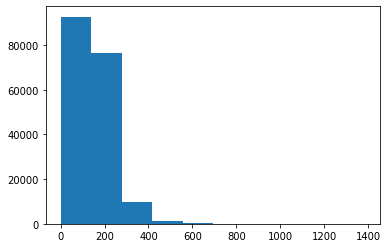

In [ ]:
# distribution of our sequences at a sequence level

import matplotlib.pyplot as plt

plt.hist(char_lens,bins=10)

In [ ]:
# find what character length covers 95% of sequences
output_seq_char_len=int(np.percentile(char_lens,95))
output_seq_char_len

290

In [ ]:
# get all keyboard characters

import string
alphabet=string.ascii_lowercase+string.digits+string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# create char level token vectorizer instance

NUM_CHAR_TOKENS=len(alphabet)+2 # add 2 for space and OOV token (OOV = out of vocab, 'UNK')

char_vectorizer=TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                               output_sequence_length=output_seq_char_len,
                               name="char_vectorizer")



In [ ]:
# adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [ ]:
# character vocab stats

char_vocab=char_vectorizer.get_vocabulary()

print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [ ]:
# test character vectorizer

random_train_char=random.choice(train_chars)
print(f"Charified text: \n {random_train_char}")
print(f"\nLength of random_train_chars: {len(random_train_char.split())}")
vectorized_char=char_vectorizer([random_train_char])
print(f"\nVectorized char:\n {vectorized_char}")
print(f"\nLength of vectorized chars: {len(vectorized_char[0])}")


Charified text: 
 t h e   s t u d y   w a s   d e s i g n e d   a s   a   p r o s p e c t i v e   r a n d o m i z e d   s t u d y   .

Length of random_train_chars: 49

Vectorized char:
 [[ 3 13  2  9  3 16 10 19 20  5  9 10  2  9  4 18  6  2 10  5  9  5 14  8
   7  9 14  2 11  3  4 21  2  8  5  6 10  7 15  4 25  2 10  9  3 16 10 19
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

## Creating a character level embeddings

In [ ]:
# create char embedding layer
char_embed=layers.Embedding(input_dim=len(char_vocab), # number of different characters 
                            output_dim=25,
                            mask_zero=True,
                            name="char_embed")

In [ ]:
# test our character embedding layer
print(f"Charified text:\n {random_train_char}\n")
char_embed_example=char_embed(char_vectorizer([random_train_char]))
print(f"Embedded chars (after vectorization and embedding): \n {char_embed_example} \n")

print(f"character embedding shape: {char_embed_example.shape}")

Charified text:
 t h e   s t u d y   w a s   d e s i g n e d   a s   a   p r o s p e c t i v e   r a n d o m i z e d   s t u d y   .

Embedded chars (after vectorization and embedding): 
 [[[-0.00248731  0.02864463 -0.00147671 ...  0.02242244  0.0406953
   -0.01869611]
  [ 0.04841504  0.00194851 -0.00947094 ...  0.02298364 -0.02796817
   -0.01882724]
  [ 0.04301525 -0.01301545 -0.02463924 ... -0.04667712  0.02211588
    0.01066954]
  ...
  [-0.04341567 -0.00091869  0.01692024 ...  0.03440892  0.04588332
    0.04797628]
  [-0.04341567 -0.00091869  0.01692024 ...  0.03440892  0.04588332
    0.04797628]
  [-0.04341567 -0.00091869  0.01692024 ...  0.03440892  0.04588332
    0.04797628]]] 

character embedding shape: (1, 290, 25)


### Building a Conv1D model to fit on character embedings

In [ ]:
# make conv1D on char only

inputs=layers.Input(shape=(1,),dtype="string")

char_vectors=char_vectorizer(inputs)
char_embeddings=char_embed(char_vectors)
x=layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(char_embeddings)
x=layers.GlobalMaxPool1D()(x)
outputs=layers.Dense(num_classes,activation="softmax")(x)
model_3=tf.keras.Model(inputs=inputs,
                       outputs=outputs,
                       name="model_3_conv1d_char_embeddings")


# compile
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [ ]:
model_3.summary()

Model: "model_3_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_5 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_24 (Dense)            (None, 

In [ ]:
# create char level datasets

train_char_dataset=tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset=tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset=tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# fit the model on chars

model_3_history=model_3.fit(train_char_dataset,
                            steps_per_epoch=int(0.1*len(train_char_dataset)),
                            epochs=3,
                            validation_data=val_char_dataset,
                            validation_steps=int(0.1*len(val_char_dataset)))


Epoch 1/3
562/562 [==============================] - 4s 6ms/step - loss: 1.2428 - accuracy: 0.4998 - val_loss: 1.0297 - val_accuracy: 0.5941
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9931 - accuracy: 0.6018 - val_loss: 0.9429 - val_accuracy: 0.6343
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9263 - accuracy: 0.6353 - val_loss: 0.8723 - val_accuracy: 0.6646


In [ ]:
# make predictions with character model only

model_3_pred_probs=model_3.predict(val_char_dataset)
model_3_pred_probs

array([[0.2841905 , 0.27437356, 0.16070406, 0.16649029, 0.11424161],
       [0.12558922, 0.37289786, 0.01836222, 0.29798967, 0.18516105],
       [0.12632239, 0.09854014, 0.06993495, 0.68136597, 0.02383656],
       ...,
       [0.02262976, 0.0858058 , 0.07424656, 0.04871481, 0.7686031 ],
       [0.01951214, 0.07117653, 0.3618993 , 0.01800013, 0.5294119 ],
       [0.42895144, 0.34474793, 0.05053347, 0.16778897, 0.0079782 ]],
      dtype=float32)

In [ ]:
# Convert prediction probabilities into class labels

model_3_preds=tf.argmax(model_3_pred_probs,axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 0])>

In [ ]:
# calculate results for conv1d model char 

model_3_results=calculate_results(y_true=val_labels_encoded,
                                  y_pred=model_3_preds)
model_3_results


{'accuracy': 65.58321196875414,
 'f1': 0.6448206485812511,
 'precision': 0.6513464574222531,
 'recall': 0.6558321196875414}

## Model 4: Combining pretrained token embeddings + characters embeddings (hybrid embedding layer)



In [ ]:
# setup token inputs/model

token_input=layers.Input(shape=[],dtype=tf.string,name="token_input")
token_embeddings=tf_hub_embedding_layer(token_input)
token_output=layers.Dense(128,activation="relu")(token_embeddings)
token_model=tf.keras.Model(inputs=token_input,
                           outputs=token_output)

# setup char inputs/model

char_inputs=layers.Input(shape=(1,),dtype=tf.string,name="char_input")
char_vectors=char_vectorizer(char_inputs)
char_embeddings=char_embed(char_vectors)
char_bi_lstm=layers.Bidirectional(layers.LSTM(25))(char_embeddings) 
char_model=tf.keras.Model(inputs=char_inputs,
                          outputs=char_bi_lstm)


# Concatenate token and char inputs (create hybrid token embeddings) 

token_char_concat=layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                char_model.output])

# create output layers 
combined_dropout=layers.Dropout(0.5)(token_char_concat)
combined_dense=layers.Dense(128,activation="relu")(combined_dropout)
final_dropout=layers.Dropout(0.5)(combined_dense)
output_layer=layers.Dense(num_classes,activation="softmax")(final_dropout)

# Construct model with char and token inputs

model_4=tf.keras.Model(inputs=[token_model.input,char_model.input],
                       outputs=output_layer,
                       name="model_4_token_and_char_embeddings")


In [ ]:
# get a summary of our model

model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

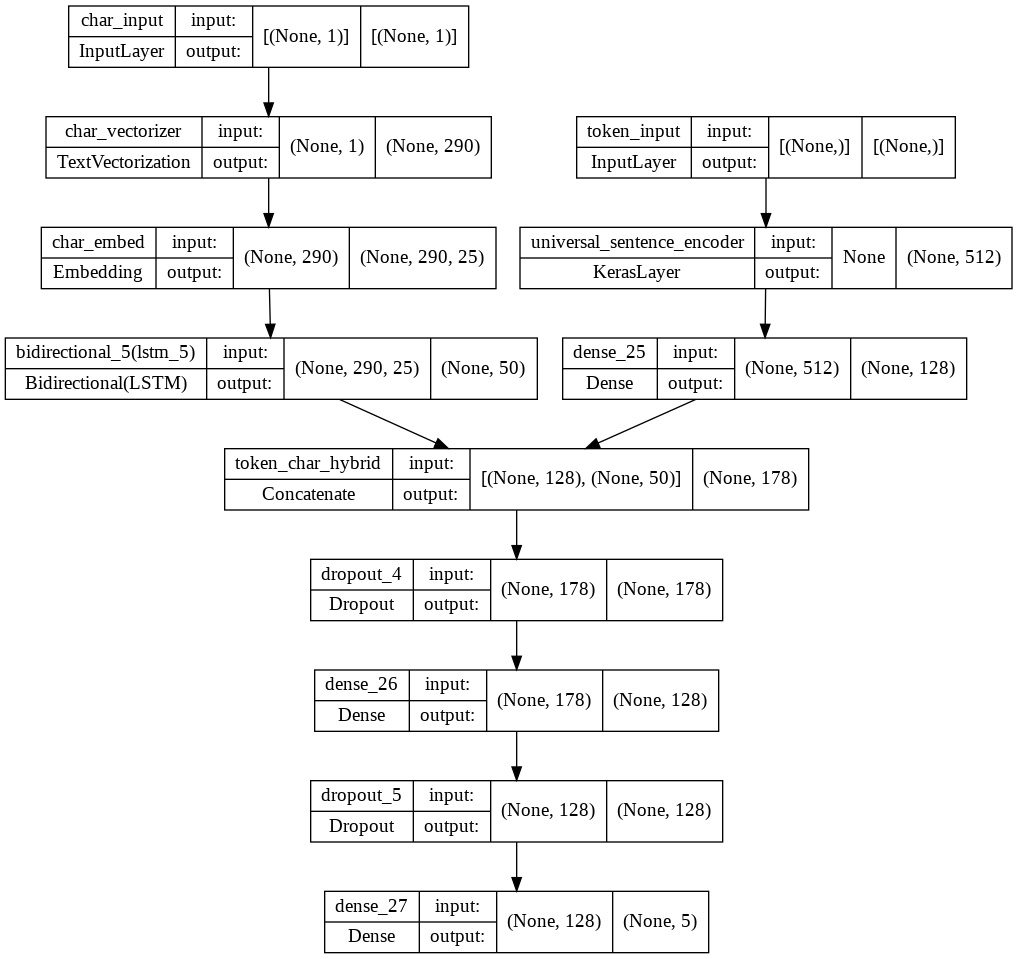

In [ ]:
# plot hybrid token and character model

from keras.utils.vis_utils import plot_model
plot_model(model_4,show_shapes=True)

In [ ]:
# compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


### Combining token and character data into a tf.data.Dataset

In [ ]:
# combine chars and tokens into  a dataset

train_char_token_data=tf.data.Dataset.from_tensor_slices((train_sentences,train_chars)) # make data
train_char_token_label=tf.data.Dataset.from_tensor_slices((train_labels_one_hot)) # make labels
train_char_token_dataset=tf.data.Dataset.zip((train_char_token_data,train_char_token_label)) # combine data and labels

# prefetch and batch train data

train_char_token_dataset=train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 



In [ ]:
 
val_char_token_data=tf.data.Dataset.from_tensor_slices((val_sentences,val_chars)) # make data
val_char_token_label=tf.data.Dataset.from_tensor_slices((val_labels_one_hot)) # make labels
val_char_token_dataset=tf.data.Dataset.zip((val_char_token_data,val_char_token_label)) # combine data and labels


val_char_token_dataset=val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE) 


In [ ]:
# check training char and token embedding dataset

train_char_token_dataset,val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences

In [ ]:
# Fit the model on token and chars
history_model_4=model_4.fit(train_char_token_dataset,
                            steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                            epochs=3,
                            validation_data=val_char_token_dataset,
                            validation_steps=int(0.1*len(val_char_token_dataset)))


Epoch 1/3
562/562 [==============================] - 38s 53ms/step - loss: 0.9919 - accuracy: 0.6049 - val_loss: 0.7801 - val_accuracy: 0.7041
Epoch 2/3
562/562 [==============================] - 27s 48ms/step - loss: 0.8064 - accuracy: 0.6916 - val_loss: 0.7221 - val_accuracy: 0.7244
Epoch 3/3
562/562 [==============================] - 24s 43ms/step - loss: 0.7749 - accuracy: 0.7065 - val_loss: 0.7002 - val_accuracy: 0.7307


In [ ]:
# evaluate the whole validation dataset

model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 21s 23ms/step - loss: 0.7014 - accuracy: 0.7295


[0.7014113068580627, 0.7295445799827576]

In [ ]:
# make predictions using the token-character model hybrid

model_4_pred_probs=model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[3.6648813e-01, 4.5772889e-01, 5.9473668e-03, 1.5708503e-01,
        1.2750582e-02],
       [2.7085048e-01, 5.3666097e-01, 3.1930872e-03, 1.8676339e-01,
        2.5321506e-03],
       [3.2859245e-01, 1.3334502e-01, 4.0432133e-02, 4.6257800e-01,
        3.5052363e-02],
       ...,
       [4.6038433e-04, 5.4034251e-03, 5.6558538e-02, 1.7922092e-04,
        9.3739843e-01],
       [8.2043279e-03, 6.4078622e-02, 2.9347810e-01, 3.5591561e-03,
        6.3067979e-01],
       [2.6666099e-01, 3.5025898e-01, 2.7783039e-01, 3.3294722e-02,
        7.1954869e-02]], dtype=float32)

In [ ]:
# format pred probs into pred labels

model_4_preds=tf.argmax(model_4_pred_probs,axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [ ]:
# get result of token-char-hybrid model

model_4_results=calculate_results(y_true=val_labels_encoded,
                                  y_pred=model_4_preds)
model_4_results

{'accuracy': 72.95445518337085,
 'f1': 0.7263432803794495,
 'precision': 0.7328876496667676,
 'recall': 0.7295445518337085}

In [ ]:
model_1_results

{'accuracy': 78.50853965311796,
 'f1': 0.7826123770203829,
 'precision': 0.781829978565315,
 'recall': 0.7850853965311797}

## Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [ ]:
train_df

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
...,...,...,...,...
180035,RESULTS,for the absolute change in percent atheroma vo...,7,11
180036,RESULTS,"for pav , a significantly greater percentage o...",8,11
180037,RESULTS,both strategies had acceptable side effect pro...,9,11
180038,CONCLUSIONS,"compared with standard statin monotherapy , th...",10,11


> **Note**: The engineered features used to train a model need to be available at test time,in this case line numbers and total lines are available.

### Create positional embeddings

In [ ]:
# number of different line numbers
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

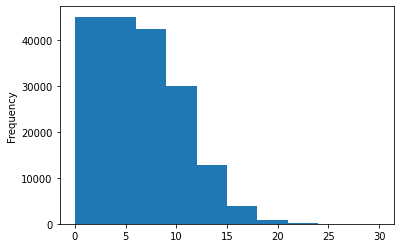

In [ ]:
# distribution of "line_number" column
train_df.line_number.plot.hist()

In [ ]:
# use tensorflow to create one-hot encoded tensors of our "line_number" column

train_line_numbers_one_hot=tf.one_hot(train_df["line_number"].to_numpy(),depth=15)
val_line_numbers_one_hot=tf.one_hot(val_df["line_number"].to_numpy(),depth=15)
test_line_numbers_one_hot=tf.one_hot(test_df["line_number"].to_numpy(),depth=15)
train_line_numbers_one_hot[:10],train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

In [ ]:
 # number of different total line values
 train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

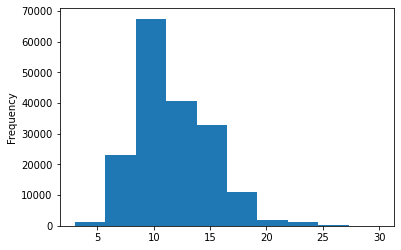

In [ ]:
# distribution of total line numbers

train_df.total_lines.plot.hist()

In [ ]:
# check the coverage of "total_lines" value

np.percentile(train_df.total_lines,98)

20.0

In [ ]:
# use tensorflow to create one-hot-encoded of our "total_lines" feature

train_total_lines_one_hot=tf.one_hot(train_df["total_lines"].to_numpy(),depth=20)
val_total_lines_one_hot=tf.one_hot(val_df["total_lines"].to_numpy(),depth=20)
test_total_lines_one_hot=tf.one_hot(test_df["total_lines"].to_numpy(),depth=20)
train_total_lines_one_hot[:10],train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

### Building a tribrid embedding model

In [ ]:
# Token inputs 

token_inputs=layers.Input(shape=[],dtype="string",name="token_inputs")
token_embeddings=tf_hub_embedding_layer(token_inputs)
token_outputs=layers.Dense(128,activation="relu")(token_embeddings)
token_model=tf.keras.Model(inputs=token_inputs,
                           outputs=token_outputs)

# Char inputs

char_inputs=layers.Input(shape=(1,),dtype="string",name="char_inputs")
char_vectors=char_vectorizer(char_inputs)
char_embeddings=char_embed(char_vectors)
char_bi_lstm=layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model=tf.keras.Model(inputs=char_inputs,
                          outputs=char_bi_lstm)


# Line numbers model

line_number_inputs=layers.Input(shape=(15,),dtype=tf.float32,name="line_number_input")
x=layers.Dense(32,activation="relu")(line_number_inputs)
line_number_model=tf.keras.Model(inputs=line_number_inputs,outputs=x)

# Total lines model

total_line_inputs=layers.Input(shape=(20,),dtype=tf.float32,name="total_lines_inputs")
y=layers.Dense(32,activation="relu")(total_line_inputs)
total_line_model=tf.keras.Model(inputs=total_line_inputs,outputs=y)

# Combine token and char embeddings into a hybrid embeddings

combined_embeddings=layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                            char_model.output])

z=layers.Dense(256,activation="relu")(combined_embeddings)
z=layers.Dropout(0.5)(z)
                                                                   
# Combine positional embedding with combined token and char cmbeddings

tribrid_embeddings=layers.Concatenate(name="char_token_positional_embeddings")([line_number_model.output,
                                                                                total_line_model.output,
                                                                                z])

# create ouput layer
output_layer=layers.Dense(num_classes,activation="softmax",name="output_layer")(tribrid_embeddings)

# put together model with all inputs

model_5=tf.keras.Model(inputs=[line_number_model.input,
                               total_line_model.input,
                               token_model.input,
                               char_model.input],
                       outputs=output_layer,
                       name="model_5_tribrid_embedding_model")



In [ ]:
# get a summary of tribrid embedding model
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['t

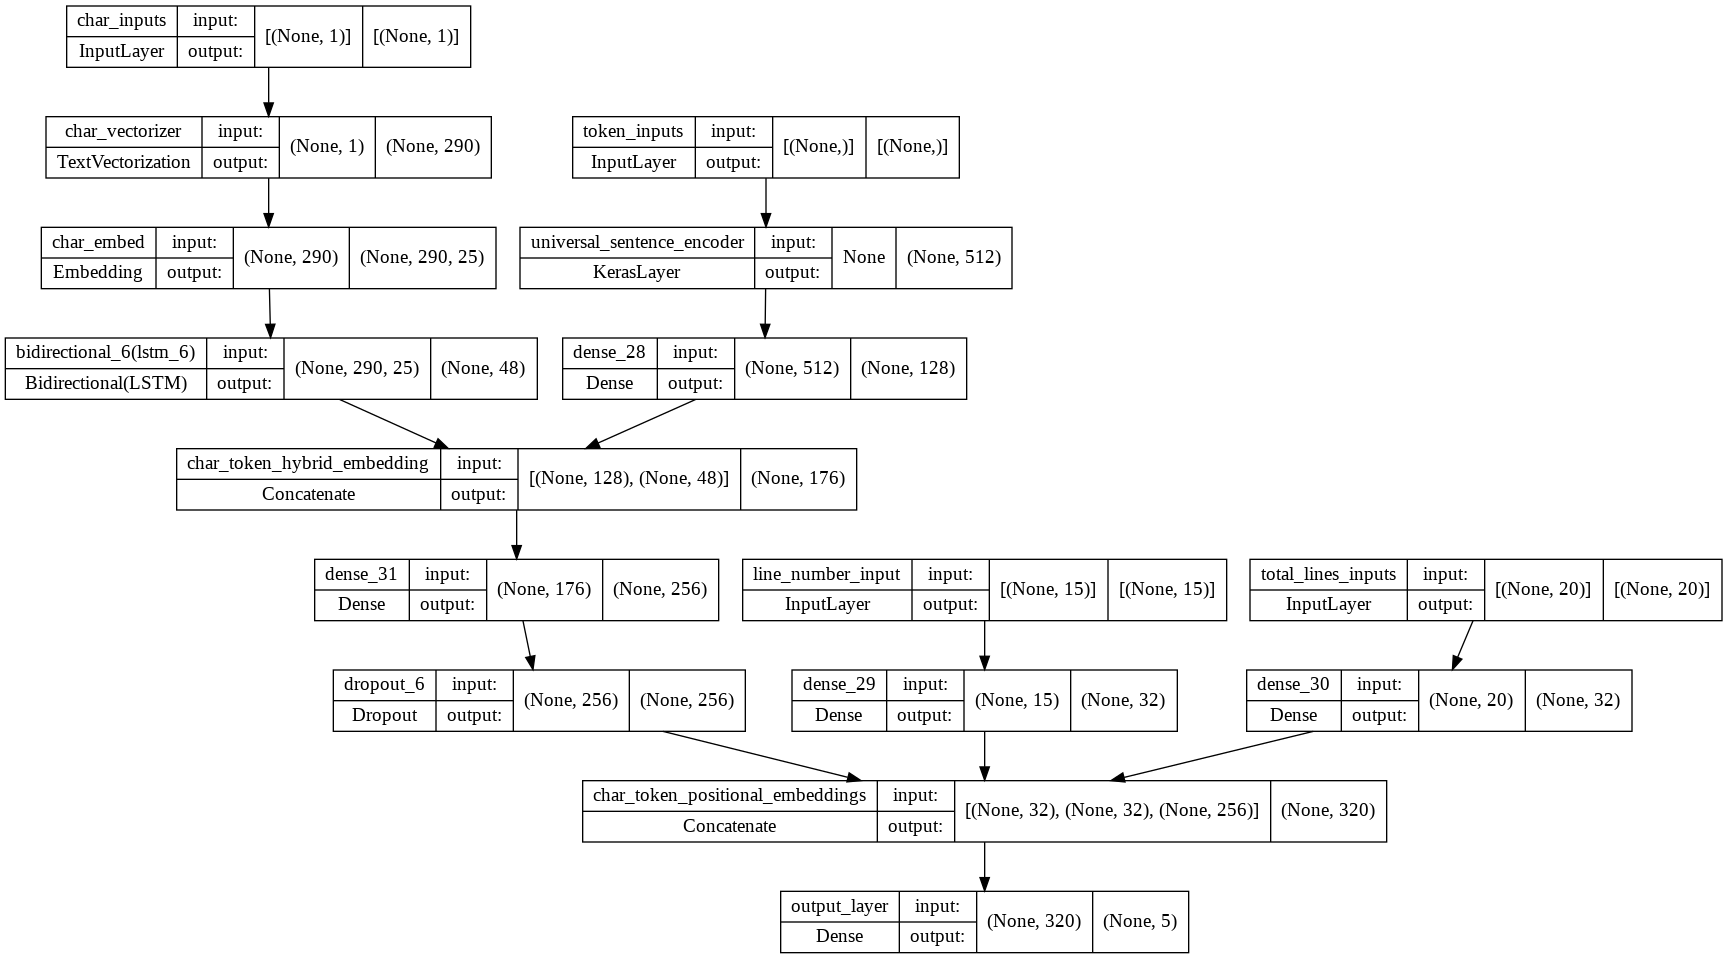

In [ ]:
# plot model_5 to explore

from keras.utils.vis_utils import plot_model

plot_model(model_5,show_shapes=True)

In [ ]:
# compile model_5
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"]) 


### Create tribrid embeddings datasets using tf.data

In [ ]:
# Create training and validation datasets with all 4 kind of input data

train_char_token_pos_data=tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                              train_total_lines_one_hot,
                                                              train_sentences,
                                                              train_chars))

train_char_token_pos_labels=tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset=tf.data.Dataset.zip((train_char_token_pos_data,train_char_token_pos_labels))

train_char_token_pos_dataset=train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


val_char_token_pos_data=tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))

val_char_token_pos_labels=tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset=tf.data.Dataset.zip((val_char_token_pos_data,val_char_token_pos_labels))

val_char_token_pos_dataset=val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [ ]:
# check input shapes

train_char_token_pos_dataset,val_char_token_pos_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting, evaluating and making predictions with our tribrid model

In [ ]:
# Fit our tribrid embedding model

history_model_5=model_5.fit(train_char_token_pos_dataset,
                            steps_per_epoch=int(0.1*len(train_char_token_pos_dataset)),
                            epochs=3,
                            validation_data=val_char_token_pos_dataset,
                            validation_steps=int(0.1*len(val_char_token_pos_dataset)))


Epoch 1/3
562/562 [==============================] - 37s 53ms/step - loss: 1.1007 - accuracy: 0.7203 - val_loss: 0.9816 - val_accuracy: 0.8072
Epoch 2/3
562/562 [==============================] - 27s 48ms/step - loss: 0.9660 - accuracy: 0.8162 - val_loss: 0.9485 - val_accuracy: 0.8225
Epoch 3/3
562/562 [==============================] - 24s 43ms/step - loss: 0.9499 - accuracy: 0.8221 - val_loss: 0.9375 - val_accuracy: 0.8285


In [ ]:
# make predictions with the char token pos model

model_5_pred_probs=model_5.predict(val_char_token_pos_dataset,verbose=1)
model_5_pred_probs

945/945 [==============================] - 25s 21ms/step


array([[0.49077696, 0.11561397, 0.01108223, 0.3648045 , 0.01772239],
       [0.51727223, 0.10923622, 0.04846567, 0.31465203, 0.01037385],
       [0.27420557, 0.11725156, 0.14737765, 0.39320073, 0.06796454],
       ...,
       [0.03360233, 0.12096204, 0.05057243, 0.03278907, 0.7620741 ],
       [0.03391131, 0.34520343, 0.0755271 , 0.02895756, 0.5164006 ],
       [0.19937126, 0.6235661 , 0.08347559, 0.0349777 , 0.05860934]],
      dtype=float32)

In [ ]:
# conveert pred probs to pred labels
model_5_preds=tf.argmax(model_5_pred_probs,axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
# calculate results of char token pos model
model_5_results=calculate_results(y_true=val_labels_encoded,
                                  y_pred=model_5_preds)
model_5_results

{'accuracy': 83.29802727393088,
 'f1': 0.8320275965498788,
 'precision': 0.8317566763488896,
 'recall': 0.8329802727393089}

In [ ]:
model_4_results

{'accuracy': 72.95445518337085,
 'f1': 0.7263432803794495,
 'precision': 0.7328876496667676,
 'recall': 0.7295445518337085}

## Model 6: Conv1D with token embeddings + character embeddings + postional embeddings

In [ ]:
# Token inputs 

token_inputs=layers.Input(shape=[],dtype="string",name="token_inputs")
text_vectors=text_vectorizer(token_inputs) # vectorize text inputs
token_embeddings=token_embed(text_vectors) # create embedding
x=layers.Conv1D(64,kernel_size=5,padding="same",activation="relu")(token_embeddings)
x=layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector from conv layer
token_outputs=layers.Dense(128,activation="relu")(x)
token_model=tf.keras.Model(inputs=token_inputs,
                           outputs=token_outputs)

# Char inputs

char_inputs=layers.Input(shape=(1,),dtype="string",name="char_inputs")
char_vectors=char_vectorizer(char_inputs)
char_embeddings=char_embed(char_vectors)
char_bi_lstm=layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model=tf.keras.Model(inputs=char_inputs,
                          outputs=char_bi_lstm)



# Line numbers model

line_number_inputs=layers.Input(shape=(15,),dtype=tf.float32,name="line_number_input")
x=layers.Dense(32,activation="relu")(line_number_inputs)
line_number_model=tf.keras.Model(inputs=line_number_inputs,outputs=x)

# Total lines model

total_line_inputs=layers.Input(shape=(20,),dtype=tf.float32,name="total_lines_inputs")
y=layers.Dense(32,activation="relu")(total_line_inputs)
total_line_model=tf.keras.Model(inputs=total_line_inputs,outputs=y)

# Combine token and char embeddings into a hybrid embeddings

combined_embeddings=layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                            char_model.output])

z=layers.Dense(256,activation="relu")(combined_embeddings)
z=layers.Dropout(0.5)(z)
                                                                   
# Combine positional embedding with combined token and char cmbeddings

tribrid_embeddings=layers.Concatenate(name="char_token_positional_embeddings")([line_number_model.output,
                                                                                total_line_model.output,
                                                                                z])

# create ouput layer
output_layer=layers.Dense(num_classes,activation="softmax",name="output_layer")(tribrid_embeddings)

# put together model with all inputs

model_6=tf.keras.Model(inputs=[line_number_model.input,
                               total_line_model.input,
                               token_model.input,
                               char_model.input],
                       outputs=output_layer,
                       name="model_6_tribrid_embedding_model")

In [ ]:
model_6.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
history_model_6=model_6.fit(train_char_token_pos_dataset,
                            steps_per_epoch=int(0.1*len(train_char_token_pos_dataset)),
                            epochs=3,
                            validation_data=val_char_token_pos_dataset,
                            validation_steps=int(0.1*len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 33s 46ms/step - loss: 0.5680 - accuracy: 0.7878 - val_loss: 0.4621 - val_accuracy: 0.8358
Epoch 2/3
562/562 [==============================] - 23s 42ms/step - loss: 0.3623 - accuracy: 0.8694 - val_loss: 0.4276 - val_accuracy: 0.8305
Epoch 3/3
562/562 [==============================] - 21s 37ms/step - loss: 0.3344 - accuracy: 0.8791 - val_loss: 0.4022 - val_accuracy: 0.8418


In [ ]:
model_6_pred_probs=model_6.predict(val_char_token_pos_dataset,verbose=1)
model_6_pred_probs


945/945 [==============================] - 17s 16ms/step


array([[5.7760847e-01, 2.7795306e-03, 7.4525434e-03, 4.1090205e-01,
        1.2574163e-03],
       [2.6715776e-01, 1.4677380e-03, 9.4038341e-03, 7.2157216e-01,
        3.9853496e-04],
       [1.1168561e-01, 7.7986647e-04, 3.4419429e-03, 8.8404721e-01,
        4.5415796e-05],
       ...,
       [3.6644205e-06, 3.0242130e-03, 3.2960107e-03, 1.7691806e-07,
        9.9367589e-01],
       [7.5974669e-03, 9.4204676e-01, 6.6667241e-03, 9.8480680e-04,
        4.2704303e-02],
       [1.4292465e-02, 9.7688830e-01, 1.8061018e-03, 6.0140411e-04,
        6.4119040e-03]], dtype=float32)

In [ ]:
model_6_preds=tf.argmax(model_6_pred_probs,axis=1)
model_6_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 3, 3, ..., 4, 1, 1])>

In [ ]:
# calculate results of char token pos model
model_6_results=calculate_results(y_true=val_labels_encoded,
                                  y_pred=model_6_preds)
model_6_results

{'accuracy': 84.45650734807361,
 'f1': 0.8446186018546734,
 'precision': 0.8458232886112702,
 'recall': 0.8445650734807362}

In [ ]:
model_5_results

{'accuracy': 83.29802727393088,
 'f1': 0.8320275965498788,
 'precision': 0.8317566763488896,
 'recall': 0.8329802727393089}

## Compare model results

In [ ]:
# combine model results into a dataframe

all_model_results=pd.DataFrame({"model_0_baseline":baseline_results,
                                "model_1_custom_token_embedding":model_1_results,
                                "model_2_pretrained_token_embedding":model_2_results,
                                "model_3_custom_char_embedding":model_3_results,
                                "model_4_hybrid_char_token_embedding":model_4_results,
                                "model_5_pos_char_token_embedding":model_5_results,
                                "model_6_pos_char_token_conv1d_embedding":model_6_results})

all_model_results=all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,78.508540,0.781830,0.785085,0.782612
model_2_pretrained_token_embedding,71.263074,0.713315,0.712631,0.709542
model_3_custom_char_embedding,65.583212,0.651346,0.655832,0.644821
model_4_hybrid_char_token_embedding,72.954455,0.732888,0.729545,0.726343
model_5_pos_char_token_embedding,83.298027,0.831757,0.832980,0.832028
model_6_pos_char_token_conv1d_embedding,84.456507,0.845823,0.844565,0.844619


In [ ]:
# reduce the accuracy to same scale as other metrics
all_model_results["accuracy"]=all_model_results["accuracy"]/100


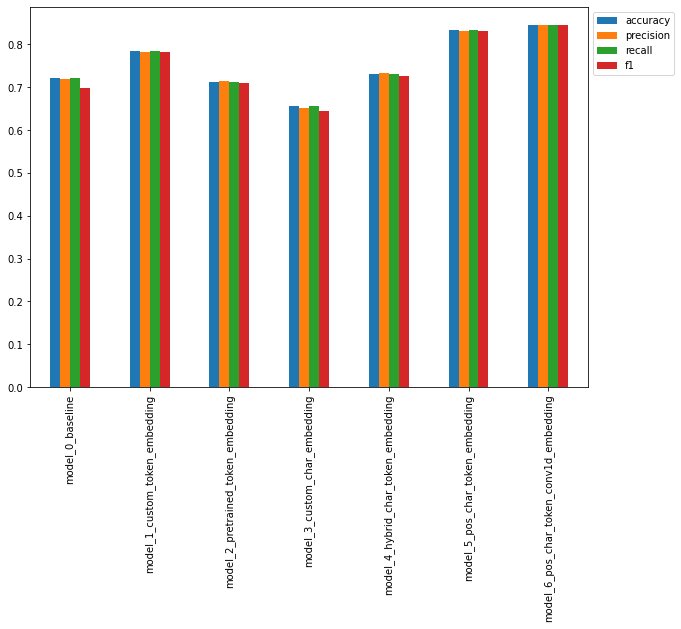

In [ ]:
# plot and compare all model results

all_model_results.plot(kind="bar",figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

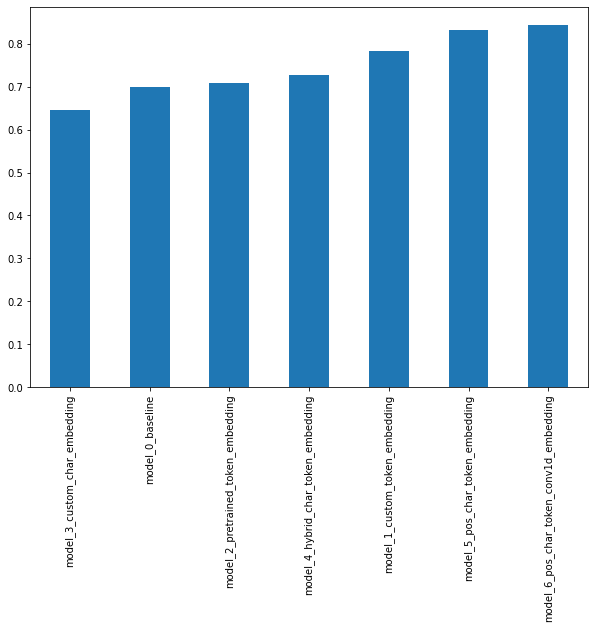

In [ ]:
# sort models results by f1-score

all_model_results.sort_values("f1",ascending=True)["f1"].plot(kind="bar",figsize=(10,7))

## Save and load model

In [ ]:
# save the best performing model to SavedModel format (default)

model_6.save("skimlit_tribrid_model")

INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


INFO:tensorflow:Assets written to: skimlit_tribrid_model/assets


In [ ]:
# load in best performing model
loaded_model=tf.keras.models.load_model("skimlit_tribrid_model")

In [ ]:
# make predictions with loaded model on the validation set
loaded_pred_probs=loaded_model.predict(val_char_token_pos_dataset)
loaded_preds=tf.argmax(loaded_pred_probs,axis=1)
loaded_preds[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 3, 3, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
# calculate the results of our loaded model

loaded_model_results=calculate_results(y_true=val_labels_encoded,
                                       y_pred=loaded_preds)

loaded_model_results

{'accuracy': 84.45650734807361,
 'f1': 0.8446186018546734,
 'precision': 0.8458232886112702,
 'recall': 0.8445650734807362}

In [ ]:
model_6_results

{'accuracy': 84.45650734807361,
 'f1': 0.8446186018546734,
 'precision': 0.8458232886112702,
 'recall': 0.8445650734807362}

In [ ]:
assert model_6_results==loaded_model_results

In [ ]:
# check the loaded model summary
loaded_model.summary()

Model: "model_6_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 55)          0           ['token_inputs[0][0]']           
 orization)                                                                                       
                                                                                                  
 token_embedding (Embedding)    (None, 55, 128)      8299648     ['text_vectorization_1[0][0]']   
                                                                                                  
 char_inputs (InputLayer)       [(None, 1)]          0           [] 

## Evaluate model on test dataset

In [ ]:
# Create test dataset batch and prefetched
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data, test_pos_char_token_labels))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check shapes
test_pos_char_token_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
# Make predictions on the test dataset
test_pred_probs = loaded_model.predict(test_pos_char_token_dataset,
                                       verbose=1)
test_preds = tf.argmax(test_pred_probs, axis=1)
test_preds[:10]

942/942 [==============================] - 13s 13ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([3, 2, 2, 2, 4, 4, 4, 1, 1, 0])>

In [ ]:
# Evaluate loaded model test predictions
loaded_model_test_results = calculate_results(y_true=test_labels_encoded,
                                              y_pred=test_preds)
loaded_model_test_results

{'accuracy': 84.07167745146839,
 'f1': 0.8407842457999898,
 'precision': 0.8422559112230507,
 'recall': 0.840716774514684}

## Find most wrong predictions

In [ ]:
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_pred_classes

['OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'RESULTS',
 'BACKGROUND',
 'BACKGROUND',
 'BACKGROUND',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'CONCLUSIONS',
 'CONCLUSIONS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'RESULTS',
 'OBJECTIVE',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'METHODS',
 'CONCLUSIONS',
 'RESUL

In [ ]:
# Create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(test_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(10)

,target,text,line_number,total_lines,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,OBJECTIVE,0.528899,False
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,METHODS,0.951499,False
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,METHODS,0.957290,False
3,RESULTS,survival analyses were used to assess the asso...,3,8,METHODS,0.976280,False
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,RESULTS,0.909474,True
5,RESULTS,when mean hemodynamic profiles were compared i...,5,8,RESULTS,0.999820,True
6,RESULTS,multivariable analyses revealed that patients ...,6,8,RESULTS,0.995825,True
7,CONCLUSIONS,abnormal lfts are common in the adhf populatio...,7,8,CONCLUSIONS,0.949887,True
8,CONCLUSIONS,elevated meld-xi scores are associated with po...,8,8,CONCLUSIONS,0.946499,True
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND,0.547080,True


In [ ]:
# Find top 100 most wrong samples (note: 100 is an abitrary number, you could go through all of them if you wanted)
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

,target,text,line_number,total_lines,prediction,pred_prob,correct
25664,CONCLUSIONS,rifampicin significantly increased the mean ar...,6,11,RESULTS,0.999978,False
2387,RESULTS,a combination prevention package including hom...,3,13,METHODS,0.999367,False
15696,RESULTS,"all @,@ people aged @ years with diagnosed dia...",2,11,METHODS,0.999183,False
28424,BACKGROUND,"however , the subgroup of subjects , which inh...",5,10,RESULTS,0.999066,False
29005,RESULTS,"we designed a patient-level , randomized , con...",3,14,METHODS,0.999003,False
...,...,...,...,...,...,...,...
9415,RESULTS,reduced dose only led to limitations in the ev...,10,12,CONCLUSIONS,0.985107,False
9878,RESULTS,counseling african americans to control hypert...,1,11,METHODS,0.985002,False
16580,OBJECTIVE,"second , we collected patient-reported outcome...",4,27,METHODS,0.984815,False
24286,RESULTS,"a two-arm , parallel rct was conducted in over...",4,9,METHODS,0.984799,False


In [ ]:
# Investigate top wrong preds
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")

Target: CONCLUSIONS, Pred: RESULTS, Prob: 0.9999775886535645, Line number: 6, Total lines: 11

Text:
rifampicin significantly increased the mean area under the plasma concentration-time curve ( auc ) of ( r ) - and ( s ) - fexofenadine ( @-fold and @-fold , respectively ) and decreased the renal clearance of ( r ) - and ( s ) - fexofenadine ( @-fold and @-fold , respectively ) , causing marked differences in the mean amounts of these enantiomers excreted into the urine in the rifampicin phase ( p < @ ) .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.999366819858551, Line number: 3, Total lines: 13

Text:
a combination prevention package including home-based voluntary testing and counseling , and art for hiv positive individuals , will be delivered in arms a and b , with art offered universally in arm a and according to national guidelines in arm b. arm c will be the control arm .

-----

Target: RESULTS, Pred: METHODS, Prob: 0.9991833567619324, Line number: 2, Total lines: 11

Text:
